# MaNGA

This code is for visualizing data from the MaNGA (*Mapping Nearby Galaxies at Apache Point Observatory*) survey, which maps the spatially-resolved spectroscopy of a large sample of nearby galaxies. The code reads FITS files that contain the flux, inverse variance, mask, and wavelength arrays for a MaNGA data cube and a MaNGA RSS (reduced spectra) file. It then creates plots of the flux as a function of wavelength for the central fiber of the RSS data and a 2D image of the H-alpha emission line for a selected *spaxel* in the data cube.

### Load Packages

We start by importing the necessary packages, including NumPy for numerical calculations, Matplotlib for plotting, Astropy for FITS file handling, and WCS (World Coordinate System) for transforming between pixel and celestial coordinates.

In [37]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from matplotlib import cm

### RSS

First, we read in the MaNGA RSS (Row-Stacked Spectra) file and assigns the flux, inverse variance, mask, wavelength, and fiber position arrays to separate variables. This represents a 1D spectrum of a star-forming galaxy

In [38]:
rss = fits.open('./manga-7443-12703-LOGRSS.fits.gz')
flux_rss = rss['FLUX'].data
ivar_rss = rss['IVAR'].data
mask_rss = rss['MASK'].data
wave_rss = rss['WAVE'].data
xpos = rss['XPOS'].data
ypos = rss['YPOS'].data

Then we create a masked array to skip plotting of bad pixels and plots the flux as a function of wavelength for the central fiber of the RSS data.

In [39]:
# Create masked array to skip plotting of bad pixels
bad_bits = (mask_rss != 0)
flux_rss_m = np.ma.array(flux_rss, mask=bad_bits)

Finally, we plot spectrum of fiber closest to (x=0, y=0) at H-alpha.

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/fiber')

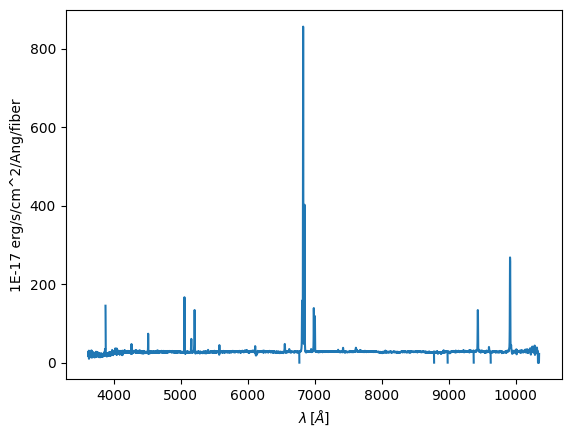

In [40]:
# index element of central fiber for this particular data cube is 1313
ind_center = 1313    
plt.plot(wave_rss, flux_rss_m[ind_center])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(rss['FLUX'].header['BUNIT'])

### Cube

Now we read in the MaNGA data cube file (3D data of the same galaxy), reorders the flux, inverse variance, and mask arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength), and assigns the wavelength and flux header arrays to separate variables. The code also finds the pixel coordinates of the central spaxel in the data cube using the CRPIX1 and CRPIX2 keywords in the flux header.

In [30]:
cube = fits.open('./manga-7443-12703-LOGCUBE.fits.gz')

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
flux = np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))

# Extracts the wavelength array and the header for the flux array from the FITS file.
wave = cube['WAVE'].data
flux_header = cube['FLUX'].header

Calculate the pixel coordinates of the center of the field of view, which are stored in the FITS header, and plots the spectrum of the central spaxel, which is the smallest spatial element in the MaNGA data cube. The wavelength is plotted on the x-axis, and the flux units are taken from the FITS header.

Text(0, 0.5, '1E-17 erg/s/cm^2/Ang/spaxel')

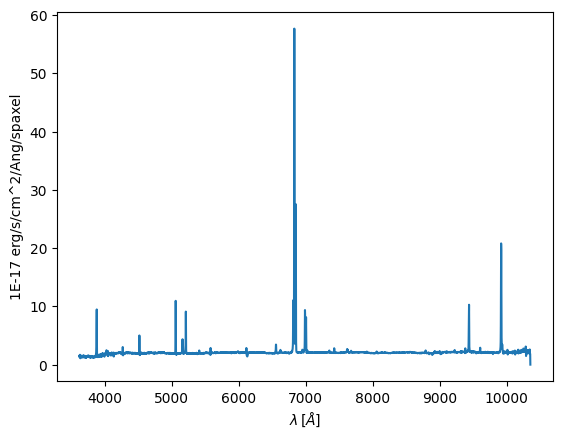

In [31]:
x_center = np.int_(flux_header['CRPIX1']) - 1
y_center = np.int_(flux_header['CRPIX2']) - 1

plt.plot(wave, flux[x_center, y_center])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])

Next, we use the WCS information in the FITS header to convert the RA and DEC coordinates of a point in the galaxy to the corresponding spaxel coordinates in the MaNGA data cube.

In [32]:
cubeWCS = wcs.WCS(flux_header)
ra = 229.525580000
dec = 42.7458420000
x_cube_coord, y_cube_coord, __ = cubeWCS.wcs_world2pix([[ra, dec, 1.]], 1)[0]
x_spaxel = np.int_(np.round(x_cube_coord)) - 1
y_spaxel = np.int_(np.round(y_cube_coord)) - 1

Here we select a region around H-alpha, using bitmasking (a bitmask uses the bits in an integer as “toggles” to indicate whether certain conditions are me). In this case spaxels that are flagged in the mask with the bit flag 2^10 are excluded. This flag indicates that the spaxel is affected by bad pixels or cosmic rays. The mask is created using a bitwise AND operation between the mask array and 2^10, followed by a comparison to zero to return a boolean mask that is True for spaxels that are flagged.

In [33]:
do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)

Next we calculate the H-alpha emission line flux for the galaxy at a redshift of 0.0402719. The wavelength range corresponding to the H-alpha line is selected using the np.where function and stored in the ind_wave variable. The flux_m masked array is sliced using this range, and the sum of the flux values for each spaxel over the range is calculated along the wavelength axis using the sum(axis=2) method. This results in a 2D array of the H-alpha emission line fluxes for each spaxel in the galaxy.

In [34]:
redshift = 0.0402719
ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2)
# Transpose array to switch the RA and DEC axes, so that the image is oriented correctly.
im = halpha.T

Now, we calculate the extent of the image in arcseconds relative to the center of the MaNGA integral field unit (IFU), which is located at (x_center, y_center) in the im array. The pixel scales in the x and y directions are extracted from the FITS header and converted from degrees to arcseconds.

In [35]:
# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

Finally, we generate the plot of H-alpha narrow band image.

Text(0, 0.5, 'arcsec')

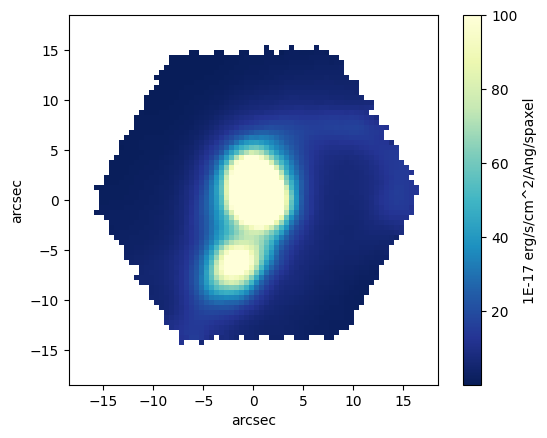

In [36]:
plt.imshow(im, extent=extent, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')